# Updates after discussion
* cleaning the 5% least frequent symbols from the vocab was a disaster since several steps can't handle unknown words. It's not impossible to fix this, but for the time being it's easier to work with the full corpus (~115k sentences instead of ~20k) and assume that this will make the weird symbols/words waaay less likely to appear. It's not an unfounded assumption (denke ich).

* top 3 seeds by freq of appearance in the corpus "is" >> "means" >> "can be found"


* Three steps for cleaning probably provide better word2word meanings but since for us the main goal is to generate a coherent sentence from the input and meaning WE are feeding, then we can't leave out punctuation symbols and stop words. Maybe it is still good to lemmatize? We'll see
* Network currently trained with  5000 trigrams, 50 epochs, hidden_s = 100, lr = 0.015. Took 17min to train. Losses went from 7.9 to 2.5
* clean corpus 5%

# Generating our descriptive sentences

## Importing everything we will need

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import random
import string
import torch
import torch.nn as nn
#is this the best choice of autograd?
from torch.autograd import Variable 
import math
import time

In [86]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.metrics import edit_distance

def word_to_synsets(word):
    """
    Converts the given word to a synset object.

    Arg:
        word: a string like 'cat'
        pos: the desired part of speech (choices: wn.NOUN, wn.VERB, wn.ADJ, wn.ADV)
    Returns:
        A string containing the first synset ID, formatted according to WordNet's conventions, e.g. 'cat.n.01',
        corresponding to that word.
    """
    # Convert word string to the synset with the corresponding part of speech.
    return wn.synsets(word)


def synset_to_word(synset):
    """
    Converts the given synset to the actual word it represents.

    Arg:
        synset: a WordNet Synset object
    Returns:
        A string containing the word corresponding to that synset.
    """
    # Convert synset to lemma, since this is what name() is defined over.
    return synset.lemmas()[0].name()


def get_antonyms(synset):
    """
    Returns all antonyms for the given synset.

    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of antonymic words as strings, if there are any, or else the empty list.
    """
    # Convert synset to lemma, since this is what the antonym relation is defined over, and get antonym(s).
    ant_lemmas = synset.lemmas()[0].antonyms()

    # Convert each antonym in this list to a string and return list (empty if no antonyms).
    return [ant_lemma.name() for ant_lemma in ant_lemmas]


def get_hypernyms(synset):
    """
    Returns all immediate hypernyms for the given synset.

    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hypernymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hyper) for hyper in synset.hypernyms()]


def get_hyponyms(synset):
    """
    Returns all immediate hyponyms for the given synset. (There are often many.)

    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hyponymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hypo) for hypo in synset.hyponyms()]


def get_synonyms(word):
    """
    Returns a set of synonyms, according to WordNet, for the given input word (using all of its senses, if
    there are multiple).

    Arg:
        word: a string representing the word whose synonyms we want.
    Returns:
        A set containing all of the other words in the same WordNet synset as the given word.
    """
    # Initialise set that will collect the synonyms.
    synonym_set = set()

    # Convert the word to a list of synsets.
    synset_list = word_to_synsets(word)

    # Get all the lemmas corresponding to the given word's synset.
    synonym_lems = [x.lemmas() for x in synset_list]

    # Go through them, get the names from the lemma (lowercasing everything for consistency), and add
    # to synonym_set.
    for lemma_list in synonym_lems:
        syn = lemma_list[0].name().lower()
        synonym_set.update( [syn] )

    # Remove from the synonym set the input word and any words that also contain the input word and return.
    to_rm = set()
    for synonym in synonym_set:
        if synonym == word or word in synonym:
            to_rm.update({synonym})

    return synonym_set.difference(to_rm)


def make_semrel_dict(word):
    """
    Creates a dictionary that contains all words standing in the given semantic relation to the main word.

    Arg:
        word: a string like 'cat' (the main word)
    Returns:
        A dictionary with the semantic relations as keys and a set of words that have that relation to all senses
        of the input word, according to WordNet, as values.
    """

    # Initialise dictionary (and we can get synonyms right away).
    semrel_dict = {
        'semrel_synonym': get_synonyms(word),
        'semrel_antonym': set(),
        'semrel_hypernym': set(),
        'semrel_hyponym': set()
    }

    # Convert the input word to all of its synsets.
    ss = word_to_synsets(word)

    # Go through each synset, determining its antonyms, hypernyms, and hyponyms, and adding each to the set in the
    # appropriate entry of the dictionary, as long as the main word does not appear as part of any of those strings.
    for s in ss:
        semrel_dict['semrel_antonym'].update( [w for w in get_antonyms(s) if word not in w] )
        semrel_dict['semrel_hypernym'].update( [w for w in get_hypernyms(s) if word not in w] )
        semrel_dict['semrel_hyponym'].update( [w for w in get_hyponyms(s) if word not in w] )

    return semrel_dict


def get_collocations(word, forbidden_wds, gensim_model, num_collocates, num_to_check = 10):
    """
    Returns minimum num_collocates most similar words to the given word based on gensim word embeddings.

    Arg:
        word: A string representing the main word.
        forbidden_wds: A set containing words as strings that may not be included as output.
        gensim_model: The pre-trained word embeddings.
        num_collocates: An integer, the number of collocates to generate.
        num_to_check: (default 10) the number of most similar words to begin with.
    Returns:
        A list of collocated words as strings.
    """

    lemmatizer = WordNetLemmatizer()

    # Use gensim's most_similar() function to get the (initially ten) words whose embeddings are most similar to the
    # input word's. Lemmatise the words to remove plural/other inflections.

    try:  # If the MW is in the word2vec vocabulary
        similar_tups = gensim_model.most_similar(word, topn=num_to_check)
        similar_wds = [lemmatizer.lemmatize( tup[0] ) for tup in similar_tups]

        # Now save only a subset of those similar words, namely the ones that:
        # - do not contain the main word
        # - are not in the passed-in set of forbidden words
        # - have a Levenshtein distance of up to 3 from the MW (i.e. are similar, probably typos)
        # - words with underscores in them, indicating multi-word units (often pretty weird)
        filtered = [wd for wd in similar_wds if (word not in wd.lower() and wd not in forbidden_wds and edit_distance(word, wd) > 4 and '_' not in wd)]
        filtered = set(filtered)

        # Recursive bit: Check if there are at least num_collocates different words in filtered (base case).
        # If not, increase the number of words to check in each recursive iteration by three and run the function again.
        # Will stop once there are minimum num_collocates words in filtered.

        if len(filtered) >= num_collocates:
            return filtered
        else:
            num_to_check += 3
            return get_collocations(word, forbidden_wds, gensim_model, num_collocates, num_to_check)

    except KeyError:  # arises when input word not in vocab
        pass


## Getting out text input

In [61]:
#opening and reading the corpus
#we will be using the full version of the descriptive corpus we made ~115k sentences
f = open('description-corpus-115k.txt', 'r')
#text = f.read()
text = f.readlines() #if we want a list with sentences as elements
f.close()

In [64]:
# getting lower case and splitting it
sentences = [text[i].lower().split() for i in range(len(text))]

In [65]:
#getting the avg length of a descriptive sentence
lengths = [len(sent) for sent in sentences]
avg_sent_length = sum(lengths)/len(lengths) # ~27

## Cleaning (NOT USED)
* Removing stop words, punctuation symbols and lemmatizing

In [86]:
# found that in some tutorials they do 3 extra cleaning steps before applying N-grams

# getting rid of stop words
#stop_words = set(nltk.corpus.stopwords.words('english'))
#stop_free = ' '.join([word for word in text.split() if word not in stop_words])
# justification --> it's like getting rid of the long tail in the word frequency plot. Oder?

# getting rid of punctuation
#punctuation_symbols = set(string.punctuation)
#punct_free = "".join(word for word in stop_free if word not in punctuation_symbols)
# makes sense.. I think

# lemmatizing?
#lemma = nltk.stem.wordnet.WordNetLemmatizer()
#normalized = ' '.join(lemma.lemmatize(word) for word in punct_free.split())
#if it is what I think it is, then it makes sense too

#last step, lower case and splitting
#cleaned_text = normalized.lower().split()

In [ ]:
text[:250]

In [ ]:
stop_free[:250]

In [ ]:
punct_free[:250]

In [ ]:
normalized[:250]

## Only normalizing (NOT USED)
* is it worth it having different tokens for cookie and cookies (in terms of having a correct sentence)?

## Implementing trigrams and setting up

In [46]:
#creating trigram sets EASY WAY
#trigrams = [([cleaned_text[i], cleaned_text[i+1]], cleaned_text[i+2])for i in range(len(cleaned_text) - 2)]

In [67]:
# better way: sentence by sentence, not the whole text in one go
# this structure allows us to create context/target sets for each word. 
trigrams = []
for sentence in sentences:
    trigrams += [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence) - 2)]

In [68]:
trigrams[0]
#context for target word 'text' --> 'a' and 'cookie'

(['it', 'does'], 'not')

In [69]:
#to prototype we will only take 5000 trigrams out of the ~500000
trigrams = trigrams[:1000]

In [70]:
# getting set of words in vocab, it's length and the frequency of each word
voc = set()
for sentence in sentences:
    voc = voc.union(set(sentence))
voc_length = len(voc) #34174
word_to_freq = {word: i for i, word in enumerate(voc)}

In [56]:
#Because we detected some errors on how our corpus is tokenized ("binoculars" is imported as bi - no -cu-lars) we will remove the 5% less frequent found words in the dictionary.
# THIS AFFECTED THE CELL BELOW. INSTEAD OF USING THIS CODE TO CLEAN THE POSSIBLE OUTPUTS WE WILL ASSUME THAT USING OUR BIGGER VERSION OF THE CORPUS SHOULD MINIMIZE 
# THE LIKELIHOOD OF FINDING THESE WEIRD TOKENS DURING THE GENERATION STEP


# freq values from dictionary to array
#freq_values = np.array([v for k, v in word_to_freq.items()])
#np.percentile(freq_values, 5) # ~1709

#getting rid of those unusual values
# creating list of keys to delete
#to_del = [k for k, v in word_to_freq.items() if v < 1709]

# deleting those elements from the word_to_freq dict
#for k in to_del: del word_to_freq[k]

In [72]:
#creating lists where we will store the input tensors
cont = []
tar = []
for context, target in trigrams:
    #creates a tensor with the frequency of both current context words
    context_freqs = torch.tensor([word_to_freq[word] for word in context], dtype = torch.long)
    #adds the tensor to inp
    cont.append(context_freqs)
    # does the same for the target and its frequency
    target_freq = torch.tensor([word_to_freq[target]], dtype = torch.long)
    tar.append(target_freq)

## Building the network 

In [73]:
#Cheking if we have access to training on GPU
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Fancy setup!')
else: 
    print('Too bad, training on CPU; dont exagerate with number of epochs.')

my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Too bad, training on CPU; dont exagerate with number of epochs.


In [74]:
class GRU(nn.Module):
    #init for input size, hidden size, output size and number of hidden layers.
    def __init__(self, input_s, hidden_s, output_s,n_layers = 1):
        super(GRU, self).__init__()
        self.input_s = input_s
        self.hidden_s = hidden_s
        self.output_s = output_s
        self.n_layers = n_layers
        # our encoder will be nn.Embedding
        # reminder: the encoder takes the input and outputs a feature tensor holding the information representing the input.
        self.encoder = nn.Embedding(input_s, hidden_s)
        #defining the GRU cell, still have to determine which parameters work best
        self.gru = nn.GRU(2*hidden_s, hidden_s, n_layers, batch_first=True, bidirectional=False)
        # defining linear decoder
        self.decoder = nn.Linear(hidden_s, output_s)
    
    def forward(self, input, hidden):
        #making sure that the input is a row vector
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1,-1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_s))

In [75]:
def train(context, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for t in range(len(trigrams)):
        output, hidden = decoder(context[t], hidden)
        loss += criterion(output, target[t])
        
    loss.backward()
    decoder_optimizer.step()
    
    return loss.data.item() / len(trigrams)

In [76]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [77]:
n_epochs = 30
print_every = 10
plot_every = 10
hidden_s = 50
n_layers = 1
lr = 0.015

decoder = GRU(voc_length, hidden_s, voc_length, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
for epoch in range(1, n_epochs + 1):
    loss = train(cont,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 1s (10 16%) 4.8687]
 0s (20 33%) 3.6161]
 59s (30 50%) 2.4126]


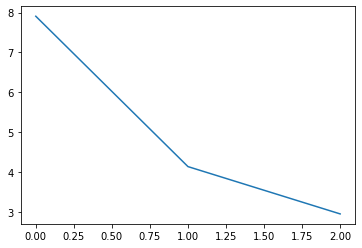

In [78]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [80]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_freq[w] for w in prime_str.split()], dtype=torch.long)
        cont = prime_input[-2:] #last two words as input
        output, hidden = decoder(cont, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_freq.keys())[list(word_to_freq.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [85]:
print(evaluate('the main', 10, temperature = 1))

the main defined can , " number reserved for christmas chestnut and


## Generating descriptive sentence
* input = main word + taboo words

The main idea here is that we will seed always with the main word and replace at the end.
The descriptive sentence will be accepted into the cleaning step (where we will make sure that no tws or the mw were used and if so, we'll replace them) if it contains at least two of the input words, besides the seeds. As long as the sentence is not accepted, we will keep generating.

To help reach a high score: once an input word has been used and its score_vector value increases, we will leave that segment in our sentence. Not sure if this hurts more than it helps, but adding the input word as a seed is VERY complicated. And not sure it would make sense either.

For a first prototype we will assume that maximum one new word is gonna be added per iteration. 

Pretty fragile with many assumptions?

It would be useful to generate a list of synonyms of all input words to expand the input_words set and have higher acceptance rate. We thought about cleaning the input words set from the start but those are words with high probability of occurence so we better leave them and clean in the end.

* maybe more seeds?
* maybe require a higher score?
* how to properly connect end of sentences and seeds? Is it better to have fewer seeds but longer auto-generated text?
* add time it to report results and "quantify" results/improvements

In [89]:
make_semrel_dict('rodrigo')

{'semrel_synonym': set(),
 'semrel_antonym': set(),
 'semrel_hypernym': set(),
 'semrel_hyponym': set()}

### 3 seeds (means, is, refers to). i=10
Final score: 

In [109]:
# set of words that we hope will appear in the description
input_words = np.array(['happy', 'pleased', 'thrilled', 'excited', 'ecstatic', 'overjoyed', 'joy'])

# extending the input_words set using semantic relations. Bigger set --> better chances of generating an approved word!


#probably good idea to check if those words are even in our vocab. jeje
# filtering out the ones that are not. Shouldn't be a thing when using larger corpus
input_words = [word for word in input_words if word in voc]

#create the first sentence
#on average a descriptive sentence had 27 words/symbols.
# we will equally divide them between our seeds

sentence_parts = np.array([evaluate('happy means', 7, temperature = 1), evaluate('happy is', 7, temperature = 1), evaluate('happy refers to', 6, temperature = 1)])

sentence =  " ".join(sentence_parts)

eval_sentence = sentence.split()
# first score vector and score
score_vector = np.array([eval_sentence.count(input_words[x]) for x in range(len(input_words))])
score_vector[0] -= 3
score = np.sum(score_vector) 

In [110]:
sentence

'happy means out cold be found of realizing emergency happy is the diabetes the can three the contributing happy refers to the before diameter your peice side'

In [ ]:
# iterate until nice sentence comes up
# we will add safety measure to not break everything
i = 0
n = 10
index_in_sentence = -1
# to keep track of scores
scores = np.zeros(n)
# the covered vector will take care that we don't replace a segment that we already "like"
covered = np.array([0,0,0])
changes = np.zeros(len(score_vector))

#known positions of input words in our sentence
positions = np.zeros(len(eval_sentence))
#we know the positions of the seeds
positions[0] = 1
positions[9] = 1
positions[18] = 1

while i < n:
    #aware that with this flow we are doing one iteration after reaching the desired score, but it's no big deal because score is designed to only go up.
    
    #checking if score improved
    new_score_vector = np.array([eval_sentence.count(input_words[x]) for x in range(len(input_words))])
    new_score_vector[0] -= 3
    changes = new_score_vector - score_vector
    
    if True in (changes>0): #there was a change. Assuming there is max 1 change per iteration from now on
        index = np.where(changes != 0)[0][0] #looking for the word that was added
        word_that_was_added = input_words[index] #if we stop assuming that, here we have to keep track of location and magnitude of changes
        #finding in which segment that new added word is in order to leave the segment untouched
        
        #how to detect the index of the word that just came up if it was already in the sentence somewhere else?
        #this should do
        indices_in_sentence = np.where(eval_sentence == word_that_was_added)[0]
        if len(indices_in_sentence) >1: #word appears at least twice
            for d in indices_in_sentence:
                if positions[d] != 1:
                    index_in_sentence = d
                    positions[d] = 1
        else:
            index_in_sentence = indices_in_sentence[0]
            positions[index_in_sentence] = 1
        #keeping the segment in which the improvement took place
        if index_in_sentence in range(9) & covered[0]!=1:
            sentence_parts[1] = evaluate('happy is', 7, temperature = 1)
            sentence_parts[2] = evaluate('happy refers to', 6, temperature = 1)
            sentence = ' '.join(sentence_parts)
            covered[0] = 1
        elif index_in_sentence in range(9, 18) & covered[1] !=1:
            sentence_parts[0] = evaluate('happy means', 7, temperature = 1)
            sentence_parts[2] = evaluate('happy refers to', 6, temperature = 1)
            sentence = ' '.join(sentence_parts)
            covered[1] = 1
        elif index_in_sentence in range(18, 27) & covered[2] != 1:
            sentence_parts[1] = evaluate('happy is', 7, temperature = 1)
            sentence_parts[0] = evaluate('happy means', 7, temperature = 1)
            sentence = ' '.join(sentence_parts)
            covered[2] = 1
        eval_sentence = sentence.split()
        changes = np.zeros(len(score_vector))
        index_in_sentence = 0
        score_vector = new_score_vector
        score = np.sum(score_vector)
    
    #if there was no change
    else: #based on what is already covered
        for r in range(len(covered)):
            if covered[r] !=1 & r==0:
                sentence_parts[r] = evaluate('happy means', 7, temperature = 1) +' '
            if covered[r] !=1 & r==1:
                sentence_parts[r] = evaluate('happy is', 7, temperature = 1) +' '
            if covered[r] !=1 & r==2:
                sentence_parts[r] = evaluate('happy refers to', 6, temperature = 1)
        sentence = ' '.join(sentence_parts)
        eval_sentence = sentence.split()
        score_vector = new_score_vector
        score = np.sum(score_vector)
        
            
    
    scores[i] = score
    i +=1

In [65]:
scores

array([ 0., -3., -3., -3., -3., -3., -3., -3., -3., -3.])